In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
# Setup.
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
import os
import json
import collections
import PIL
import wordcloud
import seaborn as sns
import bz2
from PIL import Image
from ast import literal_eval
import scipy.stats as stats
from nltk import FreqDist
from matplotlib import colors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## **Data preprocessing**
We select the data from New York Times as the study corpus because of its great influence all around the world and its multiple well-classified categories. Quotations of New York Times are selected from data ranging from 2015 to 2020 and undergo the following preprocessing: 
* We annotate the gender, nationality, and occupation and political party for speakers(as shown in the dataframe below) and use the gender and political party of the first speaker for analysis if there is more than one attribution(columns 'first_speaker_gender' and 'first_speaker_party').
* We iterate all the quotations, tokenize the quotations and sum up all the tokens.(column "all_words_counts")
* We introduce a list of approximate 100 feminine-masculine word-pairs and count the number and record the feminine and masculine words existing in all quotations.(columns "male_word_num","male_words","female_word_num","female_words")
* We find a list of 700 words generated by a relative research where researchers hired volunteers to score the 700 words (1$<$score$<$7) by their relation to female or male (For example, if word "woman" is considered more related to female, then the score will be closer to 1, otherwise it will be closer to 7). Then we count all the words existing in all quotations and compute the sum or mean of the score to analyze.(columns: "politician_word_num", "politician_words", "sum_score")
* After these data preprocessing, the data are stored in csv format for the following use.

In [109]:
# Read the data that we preprocessed previously.
df_2015 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2015_with_people_with_both_words_1.csv')
df_2016 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2016_with_people_with_both_words_1.csv')
df_2017 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2017_with_people_with_both_words_1.csv')
df_2018 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2018_with_people_with_both_words_1.csv')
df_2019 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2019_with_people_with_both_words_1.csv')
df_2020 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2020_with_people_with_both_words_1.csv')
df_2016.head(3)

,Unnamed: 0,index,Unnamed: 0.1,Unnamed: 0.1.1,index_label,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,category,Gender,Nationality,Occupation,Party,male_word_num,female_word_num,male_words,female_words,year_month,first_speaker_gender,politician_word_num,politician_words,sum_score,all_words_counts,first_speaker_party
0,0,10,10,10,10,2016-06-30-006806,He is hoping that the playwrights and actors h...,Ben Wizner,['Q21498061'],2016-06-30 00:00:00,3,"[['Ben Wizner', '0.8811'], ['None', '0.1063'],...",['http://www.nytimes.com/2016/07/01/theater/ed...,E,uncategorized,[['male']],[['United States of America']],"[['lawyer', 'writer', 'civil rights advocate']]",[['No data']],2,0,"['he', 'actors']",[],2016-06,male,1,['people'],4.185185,29,No data
1,1,11,11,11,11,2016-05-27-031063,He was holding my hands until the end,Sunao Tsuboi,['Q11425715'],2016-05-27 02:29:00,139,"[['Sunao Tsuboi', '0.5736'], ['None', '0.2992'...",['http://www.abqjournal.com/781824/obamas-hug-...,E,politics,[['male']],[['Japan']],[['educator']],[['No data']],1,0,['he'],[],2016-05,male,0,[],0.000000,8,No data
2,2,17,17,17,17,2016-09-07-040636,I just kept pushing her back and tried to make...,Caroline Wozniacki,['Q30767'],2016-09-07 00:00:00,22,"[['Caroline Wozniacki', '0.8121'], ['None', '0...",['http://asia.eurosport.com/tennis/wozniacki-d...,E,sports,[['female']],[['Denmark']],[['tennis player']],[['No data']],0,2,[],"['her', 'her']",2016-09,female,0,[],0.000000,26,No data


## **Useful functions for data visualization**
Here we have several functions for data visualization:
* **func_visualization_0**:
It gives two wordcloud figures showing the most frequently-used feminine words and masculine words.
* **func_visualization_1**: 
It focuses on the analysis on an overall level and it contains 3 sets of figures. 
 * The first set includes two lineplots illustrating how the count and ratio of masculine and feminine change as time change. 
 * The second set includes two barplots illustrating how feminine words and masculine words are used differently in different categories of the newspaper.
 * The third set includes two pieplots illustrating if people of different genders have a preference for feminine/masculine words.
* **func_visualization_2**: 
This visualization illustrates the most frequently-used 30 feminine/masculine words by the sum of their counts from 2015 to 2020.
* **func_visualization_3**:
This visualization focuses on the analysis on a party level and has 2 sets of figures.
 * The first set includes all words spoken by Republican and Democratic Party respectively and how many feminine/masculine words detected in Republican quotations and Democratic quotations.
 * The second set reflects the composition of feminine words and masculine words in all words spoken by the Republican and Democratic Party.

* **func_visualization_4**: 
This visualization tries to reflect the gender composition of speakers and how different genders use the two types of words in Republican and Democratic Party. It generates two figures.

* **func_visualization_5**: 
This visualization has two barplots and shows the gender composition of the top 50 speakers with the most sum of spoken words in Republican and Democratic Party. 

* **func_visualization_6**
This visualization has two boxplots showing the score distribution difference on gender and party level. 

More detailed explanation can be found in the following parts.

In [170]:
# functions

def sum_words(df):
  female_wordlist = []
  male_wordlist = []
  female_df = df[df['female_word_num']!=0].reset_index()
  male_df = df[df['male_word_num']!=0].reset_index()
  for line in range(female_df.shape[0]):
    female_wordlist = female_wordlist + literal_eval(female_df['female_words'][line])
  for line in range(male_df.shape[0]):
    male_wordlist = male_wordlist + literal_eval(male_df['male_words'][line])
  return female_wordlist, male_wordlist

def visualization_0(df):
  female_wordlist, male_wordlist = sum_words(df)
  fdist_female = FreqDist(female_wordlist)
  fdist_male = FreqDist(male_wordlist)
  mask_female = np.array(Image.open('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/female.png'))
  mask_male = np.array(Image.open('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/male.png'))
  wc_female = wordcloud.WordCloud(
        mask = mask_female,
        max_words = 200,
        font_path = '/content/drive/Shareddrives/ADA/Quotes_with_people/caches/CALIBRI.TTF',
        max_font_size = 200,
        background_color = 'white',
        colormap = 'RdYlGn',
        scale = 20)
  
  wc_male = wordcloud.WordCloud(
      mask = mask_male,
      max_words = 200,
      font_path = '/content/drive/Shareddrives/ADA/Quotes_with_people/caches/CALIBRI.TTF',
      max_font_size = 200,
      background_color = 'white',
      scale = 20,
      colormap = 'tab20c')

  fig = plt.figure(figsize=(10,8))
  plt.subplot(1,2,1)
  wc_female.generate_from_frequencies(fdist_female)
  image_colors = wordcloud.ImageColorGenerator(mask_female)
  plt.imshow(wc_female)
  plt.axis('off')

  plt.subplot(1,2,2)
  wc_male.generate_from_frequencies(fdist_male)
  image_colors = wordcloud.ImageColorGenerator(mask_male)
  plt.imshow(wc_male)
  plt.axis('off')


def visualization_1(dataframe_processed):
  # Part1: analyze the male/female words as time changes
  df_male = dataframe_processed[dataframe_processed['male_word_num']!=0].groupby('year_month').sum()['male_word_num']
  df_female = dataframe_processed[dataframe_processed['female_word_num']!=0].groupby('year_month').sum()['female_word_num']
  df_ratio = df_male/df_female
  fig = plt.figure(figsize=(8,6))

  ## figure1-1 male/female counts change 
  plt.subplot(2,1,1)
  plt.xlabel('time')
  plt.ylabel('number of words')
  plt.plot(df_male,label="male",color = '#bacfea')
  plt.plot(df_female,label="female",color = '#f9c1ab')
  plt.legend(loc='best')
  plt.xticks(rotation=20)
  plt.title('How does masculine words/feminine words counts change as time goes?',fontsize=11)

  ## figure1-2 ratio change
  plt.subplot(2,1,2)
  plt.xlabel('time')
  plt.ylabel('male/female words')
  plt.xticks(rotation=20)
  plt.plot(df_ratio, color = '#89b4eb')
  plt.title('How about the ratio?',fontsize=11)
  plt.tight_layout()

  ## Part2: find out the constitution of masculine and feminine words in different categories
  df2_1 = dataframe_processed[dataframe_processed['male_word_num']!=0].groupby('category').sum()['male_word_num']
  df2_2 = dataframe_processed[dataframe_processed['female_word_num']!=0].groupby('category').sum()['female_word_num']
  df2 = pd.concat([df2_1, df2_2],axis=1).fillna(0)

  ## figure2-1 masculine/feminine words counted in different categories
  plt.figure(figsize=(8,5))
  plt.subplot(1,2,1)
  x_21 = range(df2.shape[0])
  y_21 = [i+0.4 for i in x_21]
  ticks_21 = [i+0.2 for i in x_21]
  label_list = df2.T.columns
  plt.bar(x_21, height = df2['male_word_num'], width=0.4, alpha=0.8, label='male',color='#bacfea')
  plt.bar(y_21, height = df2['female_word_num'], width=0.4, alpha=0.8, label='female',color='#f9c2a9')
  plt.xlabel('category')
  plt.xticks(ticks_21, label_list, rotation=90)
  plt.title('In different categories,\n how are two types of words used?',fontsize=11)
  plt.legend() 

  ## figure2-2 In different categories, which type of words is preferred: masculine or feminine
  plt.subplot(1,2,2)
  bottom_y = df2['male_word_num']/(df2['female_word_num']+df2['male_word_num'])
  plt.ylim((-0.3,1.1))
  plt.bar(x_21,height=bottom_y, width=0.6, alpha=0.8, label='masculine words',color='#bacfea')
  plt.bar(x_21, height=1-bottom_y ,width=0.6, alpha=0.8, bottom=bottom_y, label='feminine words',color='#f9c2a9')
  plt.ylabel('percentage')
  plt.xlabel('category')
  plt.xticks(x_21, label_list, rotation=90)
  plt.legend()
  plt.title('In different categories,\nwhich type of words is preferred?',fontsize=11)
  plt.tight_layout()

  # Part3: analyze the gender of speakers

  ## figure3-1 Who contributes to the use of masculine words and is there any preference?
  df3 = dataframe_processed.groupby('first_speaker_gender').sum()[['male_word_num','female_word_num']].sort_values(by='male_word_num',ascending=False)
  label1 = ['male','female','others']
  label2 = ['masculine','feminine']
  plt.figure(figsize=(8,8))
  plt.subplot(2,2,1)
  plt.pie([df3['male_word_num']['male'],df3['male_word_num']['female'],df3['male_word_num'][2:].sum()],labels= label1,colors=['#bacfea','#fac0ab','#e0e0e0'], wedgeprops={'alpha':0.7}, autopct="%.1f%%")
  plt.title('Who contributes to the use of masculine words?',fontsize=11)
  plt.subplot(2,2,2)
  plt.pie([df3['female_word_num']['male'],df3['female_word_num']['female'],df3['female_word_num'][2:].sum()],labels= label1,colors=['#bacfea','#fac0ab','#e0e0e0'],wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Who contributes to the use of feminine words?',fontsize=11)
  plt.subplot(2,2,3)
  plt.pie([df3['male_word_num']['male'],df3['female_word_num']['male']],labels= label2,colors=['#bacfea','#fac0ab'], wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Feminine or masculine?\n Males prefer to use:',fontsize=11)
  plt.subplot(2,2,4)
  plt.pie([df3['male_word_num']['female'],df3['female_word_num']['female']],labels= label2, colors=['#bacfea','#fac0ab'],wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Feminine or masculine?\n Females prefer to use:',fontsize=11)
  plt.tight_layout()

def _barplot(ax1, df):
  female_df, male_df = sum_words(df)
  fdist_female = FreqDist(female_df)
  fdist_male = FreqDist(male_df)
  ax1_sub = ax1.twinx()
  ax1.barh(range(30),[-fdist_female.most_common(30)[29-i][1] for i in range(30)],
      tick_label=[fdist_female.most_common(30)[29-i][0] for i in range(30)],color='#fac1a9',)
  ax1_sub.barh(range(30),[fdist_male.most_common(30)[29-i][1] for i in range(30)],
      tick_label=[fdist_male.most_common(30)[29-i][0] for i in range(30)],color='#bacfea')
  ax1.spines['left'].set_visible(False)
  ax1_sub.spines['left'].set_visible(False)
  ax1.spines['right'].set_visible(False)
  ax1_sub.spines['right'].set_visible(False)
  ax1.spines['top'].set_visible(False)
  ax1_sub.spines['top'].set_visible(False)
  plt.xlabel('absolute count')
  plt.tight_layout()

def visualization_2(dfs):
  fig, (axs) = plt.subplots(1,len(dfs),figsize=(3*len(dfs),6))
  for i in range(len(dfs)):
    _barplot(axs[i], dfs[i])
    plt.title(i+2015)

def visualization_3(df):
  # select the democratic party and republican party rows
  df= df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  # how many words do democratic party and republican party say and how is the composition of feminine/masculine words
  df1 = df.groupby('first_speaker_party').sum()[['male_word_num','female_word_num','politician_word_num','all_words_counts']]
  plt.figure(figsize = (8,7))

  plt.subplot(2,2,1)
  plt.bar(df1.index, df1.all_words_counts,width=0.5,color='#bacfea')
  plt.ylabel('word counts')
  plt.title('all words counts')

  plt.subplot(2,2,2)
  plt.bar(df1.index, df1.male_word_num, width=0.5,color = '#bacfea')
  plt.bar(df1.index, df1.female_word_num, width=0.5,
              bottom=df1.male_word_num,color='#fac1a9')
  for i in range(2):
    plt.text(df1.index[i], (df1.male_word_num[i]+df1.female_word_num[i])+0.05, '%.0f' %(df1.male_word_num[i]+df1.female_word_num[i]), ha='center', va= 'bottom')
    plt.text(df1.index[i], (df1.male_word_num[i])+0.05, '%.0f%%'%(df1.male_word_num[i]/(df1.male_word_num[i]+df1.female_word_num[i])*100) ,ha='center', va= 'bottom')
  plt.ylabel('word counts')
  plt.title('masculine/feminine words composition')
  plt.legend(['masculine words','feminine words'], loc=0)

  df1['male_word_ratio'] = df1['male_word_num']/df1['all_words_counts']
  df1['female_word_ratio'] = df1['female_word_num']/df1['all_words_counts']
  plt.subplot(2,2,3)
  labels = ['masculine words','feminine words','other words']
  x_dem = [df1['male_word_ratio']['Democratic Party**'],df1['female_word_ratio']['Democratic Party**']]
  x_dem.append(1-x_dem[1]-x_dem[0])
  plt.pie(x_dem,labels = labels, colors = ['#bacfea','#fac1a9','#e0e0e0'], autopct='%1.1f%%')
  plt.title('\nDemocratic Party')

  plt.subplot(2,2,4)
  x_rep = [df1['male_word_ratio']['Republican Party**'],df1['female_word_ratio']['Republican Party**']]
  x_rep.append(1-x_rep[1]-x_rep[0])
  plt.pie(x_rep,labels = labels, colors = ['#bacfea','#fac1a9','#e0e0e0'], autopct='%1.1f%%')
  plt.title('\nRepublican Party')
  plt.tight_layout()

def visualization_4(df):
  df= df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  df_2 = df.groupby(['first_speaker_party','first_speaker_gender']).sum()[['male_word_num','female_word_num','all_words_counts']]

  plt.figure(figsize=(8,4))
  # Compute all words spoken by female or male speakers from different Parties.
  plt.subplot(1,2,1)
  male_y = [df_2['all_words_counts']['Democratic Party**']['male'],df_2['all_words_counts']['Republican Party**']['male']]
  female_y = [df_2['all_words_counts']['Democratic Party**']['female'],df_2['all_words_counts']['Republican Party**']['female']]
  labels = ['Democratic Party','Republican Party']
  x = np.arange(len(labels))
  width = 0.4
  plt.bar(x-width/2,male_y,width,label ='male speaker',color ='#bacfea')
  plt.bar(x+width/2, female_y, width,label = 'female speaker', color='#f9c2a9')
  plt.xticks(x,labels=labels)
  plt.ylabel('number of words')
  plt.legend()

  # Compute words composition of female speakers and male speakers in different parties
  plt.subplot(1,2,2)
  male_speak_female_words = [df_2['female_word_num']['Democratic Party**']['male'],df_2['female_word_num']['Republican Party**']['male']]
  male_speak_male_words = [df_2['male_word_num']['Democratic Party**']['male'],df_2['male_word_num']['Republican Party**']['male']]
  female_speak_female_words = [df_2['female_word_num']['Democratic Party**']['female'],df_2['female_word_num']['Republican Party**']['female']]
  female_speak_male_words = [df_2['male_word_num']['Democratic Party**']['female'],df_2['male_word_num']['Republican Party**']['female']]
  labels = ['Democratic Party','Republican Party']
  x = np.arange(len(labels))
  width = 0.4
  plt.bar(x-width/2,male_speak_female_words,width,label ='males speak female words',color ='#bacfea')
  plt.bar(x-width/2,male_speak_male_words,width,label ='males speak male words',bottom=male_speak_female_words,color ='#89b4eb')
  plt.bar(x+width/2, female_speak_female_words, width,label = 'females speak female words', color='#f9c2a9')
  plt.bar(x+width/2, female_speak_male_words, width,label = 'females speak male words',bottom=female_speak_female_words, color='#fa9b73')
  for i in range(2):
    plt.text(x[i]-width/2, male_speak_female_words[i]+0.05, '%.0f%%'%(male_speak_female_words[i]/(male_speak_female_words[i]+male_speak_male_words[i])*100), ha='center', va= 'bottom')
    plt.text(x[i]+width/2, female_speak_female_words[i]+0.05, '%.0f%%'%(female_speak_female_words[i]/(female_speak_female_words[i]+female_speak_male_words[i])*100), ha='center', va= 'bottom')
    plt.text(x[i]-width/2, male_speak_female_words[i]+male_speak_male_words[i]+0.05, '%.0f'%(male_speak_female_words[i]+male_speak_male_words[i]),ha='center', va= 'bottom')
    plt.text(x[i]+width/2, female_speak_female_words[i]+female_speak_male_words[i]+0.05, '%.0f'%(female_speak_female_words[i]+female_speak_male_words[i]),ha='center', va= 'bottom')
  plt.xticks(x,labels=labels)
  plt.ylabel('number of words')
  plt.legend(loc=0)
  plt.tight_layout()

def count_speaker_gender(df):
  female_speaker_counts = []
  male_speaker_counts = []
  df_to_sort = df.groupby(['speaker','first_speaker_gender','first_speaker_party']).sum().sort_values(by='all_words_counts',ascending = False)
  for i in range(10):
    if len(df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count().index)==2:
      female_speaker_counts.append(df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count()['index']['female'])
      male_speaker_counts.append(df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count()['index']['male'])
    elif df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count().index[0] == 'female':
      female_speaker_counts.append(5)
      male_speaker_counts.append(0)
    else:
      female_speaker_counts.append(0)
      male_speaker_counts.append(5)
  ratios = []
  for i in range(len(female_speaker_counts)):
    ratios.append(male_speaker_counts[i]/(male_speaker_counts[i]+female_speaker_counts[i]))
  return female_speaker_counts, male_speaker_counts, ratios

def visualization_5(df):
  df1 = df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  df2 = df.query("first_speaker_party == 'Democratic Party**'")
  df3 = df.query("first_speaker_party == 'Republican Party**'")
  # Plot the female_speaker/male_speaker number in the 50th most "influential" speakers (5 as an interval)
  fe_num, ma_num, _ = count_speaker_gender(df1)
  fe_num_d, ma_num_d, _ = count_speaker_gender(df2)
  fe_num_r, ma_num_r, _ = count_speaker_gender(df3)
  plt.figure(figsize = (7,5))
  plt.subplot(2,1,1)
  x = ['1-5','6-10','11-15','16-20','21-25','26-30','31-35','35-40','41-45','46-50']
  plt.bar(x, fe_num_d, label = 'female speaker',color = '#fac1a9')
  plt.bar(x, ma_num_d, bottom = fe_num_d, label = 'male speaker',color = '#bacfea')
  plt.ylim((-0.5,5.5))
  plt.xlim((-1,13.5))
  plt.title('gender composition in Democratic Party')
  plt.legend(loc = 7)
  plt.subplot(2,1,2)
  plt.bar(x, fe_num_r, label = 'female speaker',color = '#fac1a9')
  plt.bar(x, ma_num_r, bottom = fe_num_r, label = 'male speaker',color = '#bacfea')
  plt.ylim((-0.5,5.5))
  plt.xlim((-1,13.5))
  plt.title('gender composition in Republican Party')
  plt.legend(loc = 7)
  plt.tight_layout()

def visualization_6(df):
  df = df[df['politician_word_num']!=0].copy()
  df['average_score'] = df['sum_score']/df['politician_word_num']
  df1 = df.query('first_speaker_gender =="female" or first_speaker_gender =="male"')
  plt.figure(figsize = (8,4))
  plt.subplot(1,2,1)
  # plot the distribution of scores of different genders
  sns.boxplot(x='first_speaker_gender', y='average_score', data = df1, palette = ['#fac1a9','#bacfea'], width=0.3)
  plt.xlabel('gender of speaker')
  plt.ylabel('average score (1-7)')
  plt.title('score distribution on different gender')
  # plot the distribution of scores of different parties
  df2 = df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  plt.subplot(1,2,2)
  sns.boxplot(x='first_speaker_party', y='average_score',data =df2,palette = ['#89b4eb','#fa9b73'],width=0.3)
  plt.xlabel('party of speaker')
  plt.ylabel('average score (1-7)')
  plt.title('score distribution on different parties')
  plt.tight_layout()

## **Introduction**
Following Emma Watson's speech at the United Nations, the public is becoming more aware of gender inequality. Despite the fact that several proposals have been made to address gender imbalance, it is still unclear if the situation has improved.

The quote database provides us with an excellent corpus to examine the subject. The New York Times was chosen as the research corpus for this section owing to its widespread effect and a variety of other factors. We first choose about 100 pairs of feminine and masculine phrases (for example, actress - actor, she - he) and count how many times these feminine/masculine words appear in quotations from the New York Times from 2015 to 2020. Then we look at the gender of the speakers to see if gender has an impact on whether speakers choose feminine or masculine terms. We also compare the frequency of masculine/feminine words usage in different fields and different political parties and achieve quite interesting results.

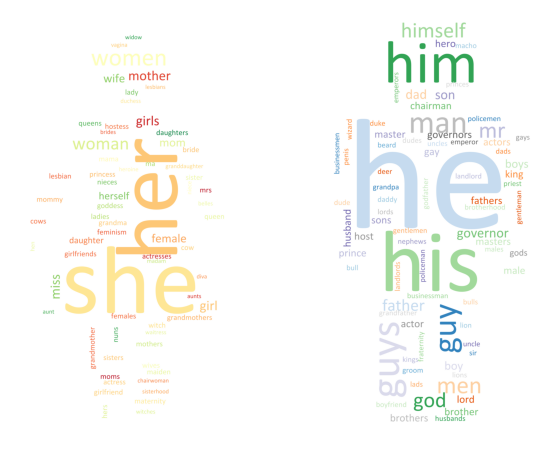

In [153]:
# Introduction: the most frequently-used feminine/masculine words
visualization_0(df_2016)

## **Data Analysis**
**Note**: Our analysis is based on data from 2015 to 2020. However, to avoid occupying too much space and causing inconvenience, we use 2016 data as a simple illustration. The other figures will be available on our websites illustrated in an interactive way. 
### **Masculine/feminine words counts and ratio change as time goes**
In the first 2 lineplots, we visualize the change of counts and ratio of masculine/feminine words throughout a year (2015-2020). From these lineplots, on one hand, we can observe an almost random change in the counts of masculine and feminine words and masculine/feminine ratio, and on the other hand, most of the masculine/feminine ratios are over 1, which indicates a higher usage of masculine words than feminine words.

### **Masculine/feminine words used in different categories**
Quotations are categorized into different fields and the masculine/feminine words ratio is computed in every field. For most fields, the masculine words percentage is mostly higher than 50%. The phenomenon is commonly observed in dataset from 2015 to 2020.

### **Who contributes to the use of masculine/feminine words?**
The speakers of masculine and feminine words are categorized by their gender and the results are visualized by 4 pie plots. From the first 2 pie plots, we can see that for the usage of both masculine and feminine words, male speakers have more contribution than female speakers. By looking at the composition of words used by males and females, we can see that males prefer to use masculine words while females use almost equally masculine words and feminine words.

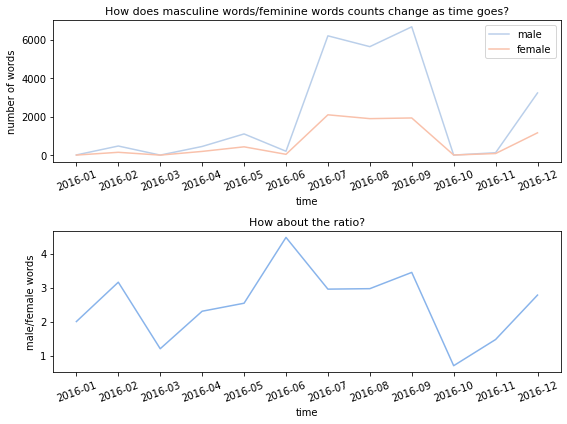

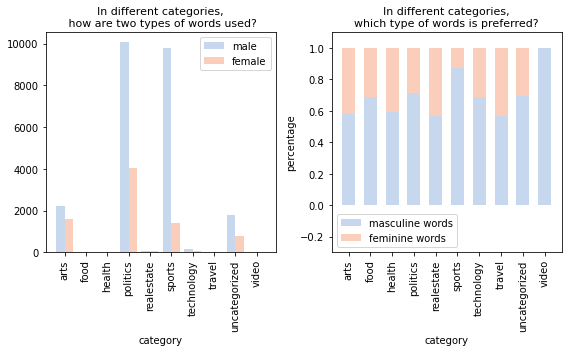

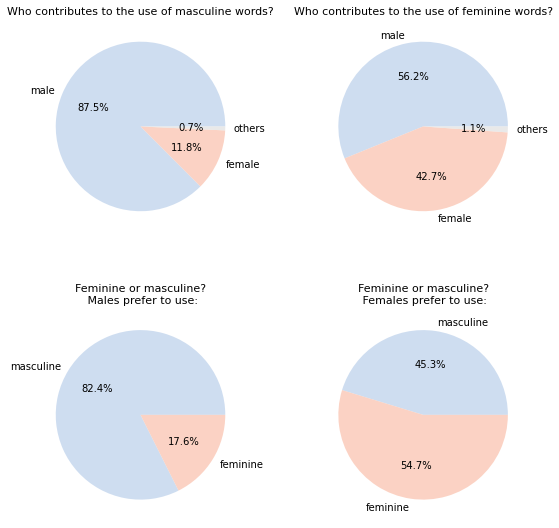

In [157]:
# To avoid occupying too much space and causing inconvenience,
visualization_1(df_2016)

### **The most frequently-used feminine/masculine words**
From 2015 to 2020, in the 30 most frequently-used feminine words "witch"("wizard"), "vagina"("penis"), "girlfriend"("boyfriend"), "maiden"("bachelor"), "spinster"("bachelor"), "feminism"("masculism") can't find their masculine-pairs in the 30 most frequently-used masculine words while vice versa, "god"("goddess"), "governor"("governess"), "chairman"("chairwoman"), "master"("mistress") can't find their feminine-pairs in the 30 most frequently-used masculine words. 

（可以做词positive和negative的分析？if来得及）

The major characters of a female in a society are woman, girl, wife, daughter, sister, lady, queen, girlfriend, witch, princess while the major characters of a male in a society are man, guy, god, father, governor, actors, husband, brother, king, hero, chairman. 


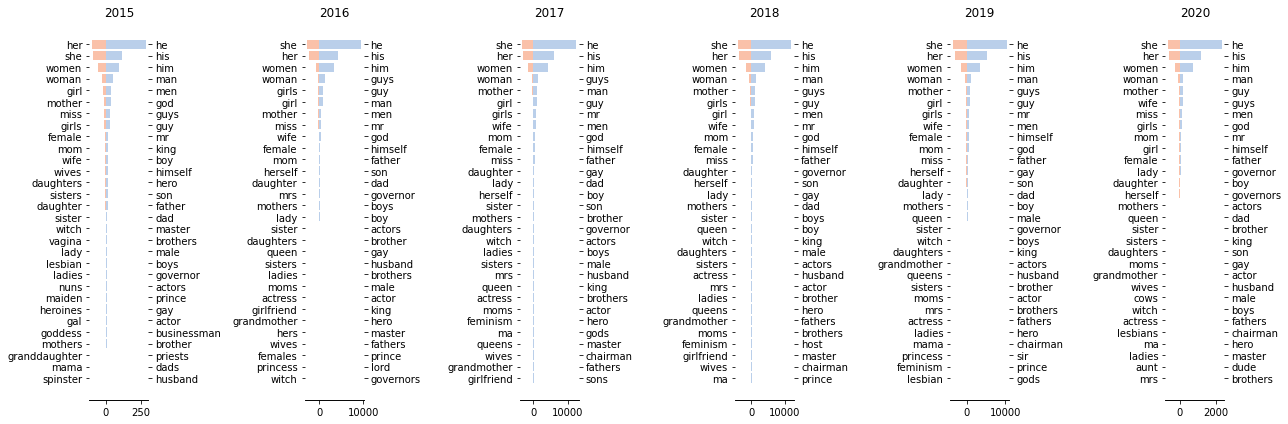

In [156]:
visualization_2([df_2015,df_2016,df_2017,df_2018,df_2019,df_2020])

### **Follow-up study**: "If there really exists a difference between languages used by Republican Party and Democratic Party?" 

### **Overall words and feminine/masculine words counts of Demoncratic Party and Republican Party** 
First we can take a look at the gender composition on an overall level, we notice that despite the difference in the sum of word tokens from Democratic Party and Republican Party, the proportion of feminine words is always higher in Republican Party.



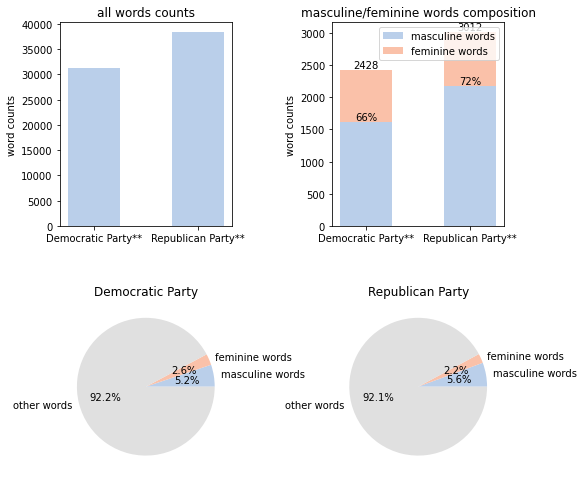

In [112]:
visualization_3(df_2016)

### **Speaker composition in two Parties**

We inspect on how much female speakers and male speakers contribute to feminine words and masculine words usage in two Parties respectively and find out that in Democratic Party, the female speakers number/males speakers number is always more balanced than in Republican Party. Male speakers tend to speak more masculine words than females while female speakers say more feminine words than male speakers in both Parties.

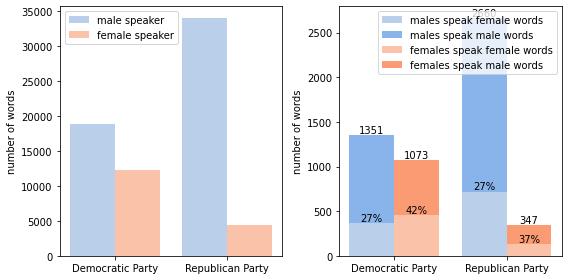

In [168]:
visualization_4(df_2016)

### **The "most influential speakers" gender composition**
We visualize the gender composition in the 50 "most influential" speakers in Democratic Party and Republican Party. 

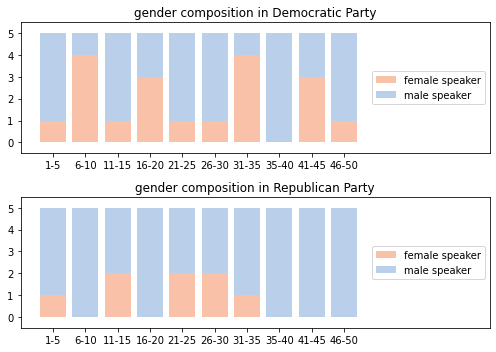

In [196]:
visualization_5(df_2017)

##### **Statistical analysis 1:** comparing the gender composition (gender ratio) in the top 50 speakers with most spoken words.

In [193]:
# compute the p-value on the two distribution
def statistical_analysis_1(df):
  df1 = df.query("first_speaker_party == 'Democratic Party**'")
  df2 = df.query("first_speaker_party == 'Republican Party**'")
  _,_, ratio_d = count_speaker_gender(df1)
  _,_, ratio_r = count_speaker_gender(df2)
  _,p_levene = stats.levene(ratio_d,ratio_r)
  if p_levene >0.05:
    print('p-value({}) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances'.format(p_levene))
  else:
    print('p-value({}) of levene test is <0.05, indicating statistically significant evidence shows two distributions have different variances'.format(p_levene))
  # According to the levene result, no statistically significant evidence shows two distributions have different variances.
  _,p_ttest = stats.ttest_ind(ratio_d,ratio_r)
  if p_ttest <0.05:
    print('p-value({}) of t-test is < 0.05, indicating the mean value of two distributions are statistically different.'.format(p_ttest))
  else:
    print('p-value({}) of t-test is > 0.05, indicating no evidence shows the mean value of two distributions are statistically different.'.format(p_ttest))

  # p<0.05 indicates two samples are statistically different at 95% confidence level.

In [195]:
print('2015')
statistical_analysis_1(df_2015)
print('2016')
statistical_analysis_1(df_2016)
print('2017')
statistical_analysis_1(df_2017)
print('2018')
statistical_analysis_1(df_2018)
print('2019')
statistical_analysis_1(df_2019)
print('2020')
statistical_analysis_1(df_2020)

2015
p-value(0.42395277691927025) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.02766703937466151) of t-test is < 0.05, indicating the mean value of two distributions are statistically different.
2016
p-value(0.11770150905630472) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.00024024631448353167) of t-test is < 0.05, indicating the mean value of two distributions are statistically different.
2017
p-value(0.4988298659457183) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.05771722672432426) of t-test is > 0.05, indicating no evidence shows the mean value of two distributions are statistically different.
2018
p-value(0.7730461433085736) of levene test is >0.05, indicating no statistically significant evidence shows two distributions 

#### **Q3.** If the results achieved by the paper is also valid in our dataset?
We introduced the word list with scores on 700 selected words (ranging from 1-7, most feminine - most masculine) and calculated the average score on Republican Party and Democratic Party.

##### **Statistical analysis 2:** compare the mean of scores achieved by Democratic Party and Republican Party.

In [189]:
def statistical_analysis_2(df):
  df = df[df['politician_word_num']!=0].copy()
  df['average_score'] = df['sum_score']/df['politician_word_num']
  df2 = df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  # perform t-test on different groups
  _, p_levene = stats.levene(df2[df2['first_speaker_party']=='Democratic Party**']['average_score'],df2[df2['first_speaker_party']=='Republican Party**']['average_score'])
  if p_levene > 0.05:
    print('p-value({}) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances'.format(p_levene))
  else:
    print('p-value({}) of levene test is <0.05, indicating statistically significant evidence shows two distributions have different variances'.format(p_levene))
  # According to the levene result, no statistically significant evidence shows two distributions have different variances.
  _, p_ttest = stats.ttest_ind(df2[df2['first_speaker_party']=='Democratic Party**']['average_score'],df2[df2['first_speaker_party']=='Republican Party**']['average_score'])
  if p_ttest < 0.05:
    print('p-value({}) of t-test is < 0.05, indicating the mean values of two distributions are statistically different.'.format(p_ttest))
  else:
    print('p-value({}) of t-test is > 0.05, indicating no evidence shows the mean values of two distributions are statistically different.'.format(p_ttest))

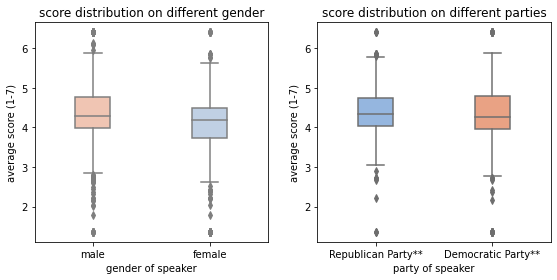

In [187]:
visualization_6(df_2020)

In [190]:
print('2015')
statistical_analysis_2(df_2015)
print('2016')
statistical_analysis_2(df_2016)
print('2017')
statistical_analysis_2(df_2017)
print('2018')
statistical_analysis_2(df_2018)
print('2019')
statistical_analysis_2(df_2019)

2015
p-value(0.17559740365803492) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.4744630733690447) of t-test is > 0.05, indicating no evidence shows the mean values of two distributions are statistically different.
2016
p-value(0.26677313171295186) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.34884183129659396) of t-test is > 0.05, indicating no evidence shows the mean values of two distributions are statistically different.
2017
p-value(0.7377950078790122) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.0011800111135578538) of t-test is < 0.05, indicating the mean values of two distributions are statistically different.
2018
p-value(0.6385520579299859) of levene test is >0.05, indicating no statistically significant evidence shows

After performing t-test between Republican Party and Democratic Party, the mean value is proven to be statistically different at 95% confidence level, which indicates difference exists between Democratic Party and Republican Party in the use of language. The results is consistent to the conclusion of the reference paper.